## Setup

In [2]:
import cv2
import numpy as np
from pyzbar.pyzbar import decode
import matplotlib.pyplot as plt
from ultralytics import YOLO
from PIL import Image
import time

In [3]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))
torch.cuda.set_device(0)

True
NVIDIA GeForce RTX 4060 Laptop GPU


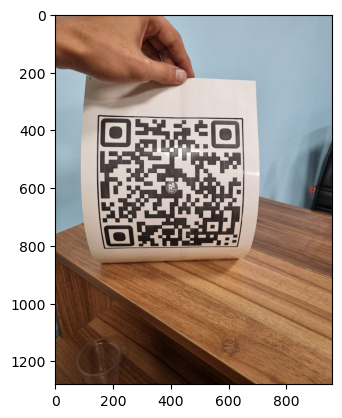

In [4]:
img_path = r"C:\Users\JoJo\Downloads\qrcode\photo_10_2024-08-27_16-26-13.jpg"
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
plt.imshow(img)

## Yolo Detection

In [3]:
model = YOLO('qr.pt')


0: 640x480 1 qrcode, 23.4ms
Speed: 3.0ms preprocess, 23.4ms inference, 3.5ms postprocess per image at shape (1, 3, 640, 480)
144 352 663 812


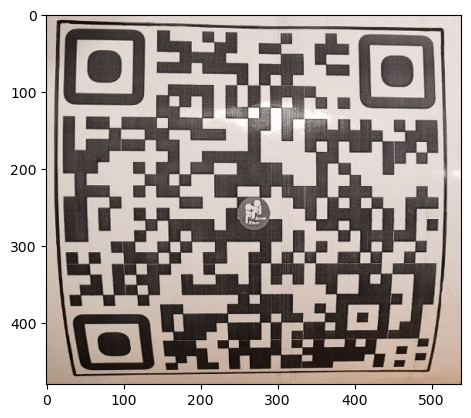

In [7]:
results = model(img, conf=0.5)

for r in results:
    boxes = r.boxes.xyxy
    for box in boxes:
        x1, y1, x2, y2 = map(int, box.cpu().numpy())
        # x1 = x1-5
        # y1 = y1-5
        # x2 = x2+10
        # y2 = y2+10
        # cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
        image=img[y1-10:y2+10, x1-10:x2+10]
print(x1, y1, x2, y2)
plt.imshow(image)

## Contour detection

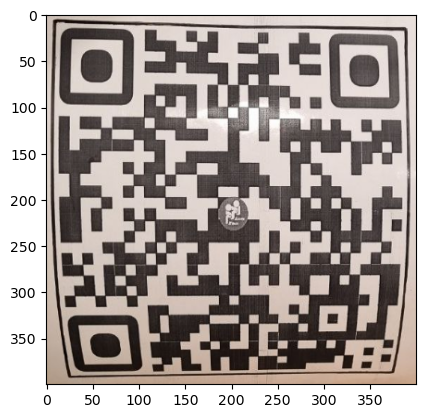

In [5]:
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# Detect edges using Canny
edges = cv2.Canny(gray, 50, 150)

# # Detect contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

# Assume the largest contour is the QR code
largest_contour = contours[0]

# Get the bounding box of the contour
x, y, w, h = cv2.boundingRect(largest_contour)

# Crop the QR code area
image = img[y-10:y+h+10, x-10:x+w+10]
image = cv2.resize(image, (400, 400))
# Show the original and unwrapped image
plt.imshow(image)

### Barrel Distortion

In [6]:
def check_found(qr):
    if(len(qr) != 0):
        print(qr)
        return True
    else:
        return False

def adjust_gamma(image, gamma=1.0):
    # Create a lookup table for all possible pixel values [0, 255]
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")

    # Apply gamma correction using the lookup table
    return cv2.LUT(image, table)

def preprocess(image):
    # image = adjust_gamma(image, 0.4)
    
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # gray = cv2.equalizeHist(gray)
    
    # Detect edges using Canny
    edges = cv2.Canny(gray, 50, 150)
    
    result = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    result = cv2.resize(result, (400, 400))
    
    blur = cv2.GaussianBlur(result, (5, 5), 0)
    ret, bw_im = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # bw_im = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,2)

    canny = cv2.Canny(result, 80, 120)

    src_points, dst_points = corners(canny)

    return bw_im

def corners(canny):
    # plt.imshow(canny, cmap='gray')
    q1 = []
    for j in range(0, 50):
        for i in range(0, 50):
            if canny[j, i] == 255:
                x = i**2 + j**2
                q1.append([i, j, x])
    if(len(q1) != 0):
        q1 = min(q1, key=lambda pair: pair[2])
        q1 = [q1[0], q1[1]]
        # print(q1)
    else:
        return np.float32([]), np.float32([]) 
    
    q2 = []
    for j in range(0, 50):
        for i in range(350, 400):
            if canny[j, i] == 255:
                x = j**2 + (400 - i)**2
                q2.append([i, j, x])
    if(len(q2) != 0):
        q2 = min(q2, key=lambda pair: pair[2])
        q2 = [q2[0], q2[1]]
        # print(q2)
    else:
        return np.float32([]), np.float32([]) 
    
    q3 = []
    for j in range(350, 400):
        for i in range(0, 50):
            if canny[j, i] == 255:
                x = i**2 + (400 - j)**2
                q3.append([i, j, x])
    if(len(q3) != 0):
        q3 = min(q3, key=lambda pair: pair[2])
        q3 = [q3[0], q3[1]]
        # print(q3)
    else:
        return np.float32([]), np.float32([])    
    
    q4 = []
    for j in range(350, 400):
        for i in range(350, 400):
            if canny[j, i] == 255:
                x = (400 - i)**2 + (400 -j)**2
                q4.append([i, j, x])
    if(len(q4) != 0):                
        q4 = min(q4, key=lambda pair: pair[2])
        q4 = [q4[0], q4[1]]
        # print(q4)
    else:
        return np.float32([]), np.float32([]) 
    
    q5 = [0, 0]
    j = int((q1[1]+q3[1])/2)
    for i in range(0, 50):
        if canny[j, i] == 255:
            q5[0]=i
            break
    q5[1]=j
    # print(q5)
    
    q6 = [0, 0]
    j = int((q2[1]+q4[1])/2)
    for i in range(350, 400):
        if canny[j, i] == 255 and i>q6[0]:
            q6[0]=i
    q6[1]=j
    # print(q6)

    # q7=[0, 0]
    # j=int((q1[1]+q5[1])/2)
    # for i in range(0, 50):
    #     if canny[j, i] == 255:
    #         q7[0] = i
    #         break

    # q8 = [0, 0]
    # j = int((q5[1] + q3[1])/2)
    # for i in range(0, 50):
    #     if canny[j, i] == 255:
    #         q8[0] = i
    #         break

    # q9 = [0, 0]
    # j = int((q2[1] + q6[1])/2)
    # for i in range(350, 400):
    #     if canny[j, i]==255:
    #         q9[0] = i

    # q10 = [0, 0]
    # j = int((q6[1] + q4[1])/2)
    # for i in range(350, 400):
    #     if canny[j, i]==255:
    #         q10[0] = i
        
    
    src_points = np.float32([q1, q2, q3, q4, q5, q6])  # Note the order: TL, TR, BR, BL
    dst_points = np.float32([[0,0], [400, 0], [0,400], [400,400], [0,200], [400, 200]])
    # print(src_points)
    return src_points, dst_points


def undistort_image(image, k1, k2, p1, p2, k3=0):
    h, w = image.shape[:2]
    # Camera matrix 
    K = np.array([[w, 0, w / 2],
                  [0, w, h / 2],
                  [0, 0, 1]], dtype=np.float32)

    # Distortion coefficients
    D = np.array([k1, k2, p1, p2, k3], dtype=np.float32)

    # Undistort the image
    new_camera_matrix, _ = cv2.getOptimalNewCameraMatrix(K, D, (w, h), 1, (w, h))
    undistorted_image = cv2.undistort(image, K, D, None, new_camera_matrix)
    
    return undistorted_image


def apply_perspective_transform(image, src_points, dst_points):
    
    # Calculate the homography matrix
    matrix, _ = cv2.findHomography(src_points, dst_points)
    
    # Apply the perspective transformation
    transformed_image = cv2.warpPerspective(image, matrix, (image.shape[1], image.shape[0]))
    return transformed_image

In [ ]:
found = False
qr=[]

start = time.time()

qr = decode(image)

if check_found(qr) == False:
    # processed_image = cropped
    processed_image = preprocess(image)
    plt.imshow(processed_image, cmap='gray')
    p1 = 0.0
    p2 = 0.0
    for k1 in np.arange(-0.6, 0.55, 0.05):
        for k2 in np.arange(-0.4, 0.55, 0.05):
            undistorted_image = undistort_image(processed_image, k1, k2, p1, p2)
            canny = cv2.Canny(undistorted_image, 80, 120)
            src_points, dst_points = corners(canny)
            if len(src_points) != 0:
                flattened_image = apply_perspective_transform(undistorted_image, src_points, dst_points)
                qr = decode(flattened_image)
                cv2.imshow(f"{k1 , k2}", flattened_image)
                cv2.waitKey(0)
            found = check_found(qr)
            if found:
                plt.imshow(flattend_image)
                break
        if found:
            break

stop = time.time()
print(f"time = {(stop - start)*100} ms")